In [1]:
import os, sys, torch

PROJECT_ROOT = "/home/numpyyy/OpenPCDet"
os.chdir(PROJECT_ROOT)

# Make sure the repo is at the *front* of sys.path
if PROJECT_ROOT not in sys.path:
    sys.path.insert(0, PROJECT_ROOT)

import pcdet
print("Using pcdet from:", pcdet.__file__)
print("Python exec:", sys.executable)
print("CUDA available:", torch.cuda.is_available())


Using pcdet from: /home/numpyyy/OpenPCDet/pcdet/__init__.py
Python exec: /home/numpyyy/openpcdet-env/bin/python
CUDA available: True


In [2]:
from pcdet.config import cfg, cfg_from_yaml_file
from pcdet.utils import common_utils

cfg_file = "tools/cfgs/kitti_models/pointpillar.yaml"
cfg_from_yaml_file(cfg_file, cfg)

logger = common_utils.create_logger()
logger.info("Notebook Training Starting...")

2025-12-14 08:03:35,439   INFO  Notebook Training Starting...


In [3]:
from torch.utils.data import DataLoader
from pcdet.datasets import build_dataloader
from pcdet.utils import common_utils
from copy import deepcopy

logger = common_utils.create_logger()

# ========================
# BUILD TRAIN DATASET ONLY
# ========================
train_set, _, train_sampler = build_dataloader(
    dataset_cfg=cfg.DATA_CONFIG,
    class_names=cfg.CLASS_NAMES,
    batch_size=4,
    dist=False,
    workers=0,
    logger=logger,
    training=True,
    merge_all_iters_to_one_epoch=False,
    total_epochs=10,
    seed=666
)

train_loader = DataLoader(
    train_set,
    batch_size=4,
    shuffle=(train_sampler is None),
    num_workers=14,
    pin_memory=True,
    persistent_workers=True,
    drop_last=True,
    collate_fn=train_set.collate_batch
)

# ========================
# BUILD VALIDATION DATASET
# ========================
val_cfg = deepcopy(cfg.DATA_CONFIG)
val_cfg.DATA_SPLIT.train = 'val'
val_cfg.INFO_PATH.train = ['kitti_infos_val.pkl']

val_set, val_loader, val_sampler = build_dataloader(
    dataset_cfg=val_cfg,
    class_names=cfg.CLASS_NAMES,
    batch_size=1,
    dist=False,
    workers=4,
    logger=logger,
    training=True
)


2025-12-14 08:03:37,603   INFO  Database filter by min points Car: 14357 => 13532
2025-12-14 08:03:37,603   INFO  Database filter by min points Car: 14357 => 13532
2025-12-14 08:03:37,605   INFO  Database filter by min points Pedestrian: 2207 => 2168
2025-12-14 08:03:37,605   INFO  Database filter by min points Pedestrian: 2207 => 2168
2025-12-14 08:03:37,606   INFO  Database filter by min points Cyclist: 734 => 705
2025-12-14 08:03:37,606   INFO  Database filter by min points Cyclist: 734 => 705
2025-12-14 08:03:37,625   INFO  Database filter by difficulty Car: 13532 => 10759
2025-12-14 08:03:37,625   INFO  Database filter by difficulty Car: 13532 => 10759
2025-12-14 08:03:37,629   INFO  Database filter by difficulty Pedestrian: 2168 => 2075
2025-12-14 08:03:37,629   INFO  Database filter by difficulty Pedestrian: 2168 => 2075
2025-12-14 08:03:37,632   INFO  Database filter by difficulty Cyclist: 705 => 581
2025-12-14 08:03:37,632   INFO  Database filter by difficulty Cyclist: 705 => 

In [4]:
from pcdet.models import build_network

model = build_network(model_cfg=cfg.MODEL, num_class=len(cfg.CLASS_NAMES), dataset=train_set)
model.cuda()
model.train()

logger.info("Model built successfully.")


/home/numpyyy/openpcdet-env/lib/python3.8/site-packages/torch/cuda/__init__.py:497: UserWarning: Can't initialize NVML
  warnings.warn("Can't initialize NVML")
/home/numpyyy/openpcdet-env/lib/python3.8/site-packages/torch/functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3190.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]
2025-12-14 08:03:46,360   INFO  Model built successfully.
2025-12-14 08:03:46,360   INFO  Model built successfully.


In [5]:
import torch

opt_cfg = cfg.OPTIMIZATION

optimizer = torch.optim.Adam(
    model.parameters(),
    lr=opt_cfg.LR / opt_cfg.DIV_FACTOR,
    weight_decay=opt_cfg.WEIGHT_DECAY
)

print("Optimizer initialized (adam_onecycle).")


Optimizer initialized (adam_onecycle).


In [6]:
from torch.optim.lr_scheduler import OneCycleLR

total_iters_each_epoch = len(train_loader)
total_epochs = opt_cfg.NUM_EPOCHS
total_steps = total_iters_each_epoch * total_epochs

lr_scheduler = OneCycleLR(
    optimizer,
    max_lr=opt_cfg.LR,
    total_steps=total_steps,
    pct_start=opt_cfg.PCT_START,
    anneal_strategy="cos",
    div_factor=opt_cfg.DIV_FACTOR,
    final_div_factor=1 / opt_cfg.LR_CLIP,
    three_phase=False,
)

print("OneCycleLR scheduler initialized.")


OneCycleLR scheduler initialized.


In [7]:
print(model)

PointPillar(
  (vfe): PillarVFE(
    (pfn_layers): ModuleList(
      (0): PFNLayer(
        (linear): Linear(in_features=10, out_features=64, bias=False)
        (norm): BatchNorm1d(64, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
      )
    )
  )
  (backbone_3d): None
  (map_to_bev_module): PointPillarScatter()
  (pfe): None
  (backbone_2d): BaseBEVBackbone(
    (blocks): ModuleList(
      (0): Sequential(
        (0): ZeroPad2d((1, 1, 1, 1))
        (1): Conv2d(64, 64, kernel_size=(3, 3), stride=(2, 2), bias=False)
        (2): BatchNorm2d(64, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
        (3): ReLU()
        (4): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (5): BatchNorm2d(64, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
        (6): ReLU()
        (7): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (8): BatchNorm2d(64, eps=0.001, moment

In [8]:
import sys
print(sys.executable)


/home/numpyyy/openpcdet-env/bin/python


In [9]:
print("Train Dataset Class:", type(train_set))
collate_fn=train_set.collate_batch
print("Collate FN:", train_loader.collate_fn)


Train Dataset Class: <class 'pcdet.datasets.kitti.kitti_dataset.KittiDataset'>
Collate FN: <function DatasetTemplate.collate_batch at 0x7ff8058b30d0>


In [10]:
batch_dict = next(iter(train_loader))
import torch
print(type(batch_dict['voxels']), isinstance(batch_dict['voxels'], torch.Tensor))
print(batch_dict['voxels'].shape)


<class 'numpy.ndarray'> False
(16416, 32, 4)


In [11]:
import numpy as np
import torch
from torch.cuda.amp import autocast, GradScaler

device = torch.device('cuda')
scaler = GradScaler()    # For AMP

def move_batch_to_gpu(batch_dict, device):
    """Move only numeric arrays to GPU (same behavior as OpenPCDet load_data_to_gpu)."""
    for key, val in batch_dict.items():
        if isinstance(val, np.ndarray):
            # Only convert numeric numpy arrays → torch tensors
            if np.issubdtype(val.dtype, np.number):
                batch_dict[key] = torch.from_numpy(val).to(device)
            else:
                # Leave string/object arrays unchanged
                batch_dict[key] = val

        elif isinstance(val, torch.Tensor):
            batch_dict[key] = val.to(device)

        else:
            batch_dict[key] = val

    return batch_dict


2025-12-14 08:03:57,365   INFO  Database filter by min points Car: 14357 => 13532
2025-12-14 08:03:57,365   INFO  Database filter by min points Car: 14357 => 13532
2025-12-14 08:03:57,365   INFO  Database filter by min points Car: 14357 => 13532
2025-12-14 08:03:57,367   INFO  Database filter by min points Pedestrian: 2207 => 2168
2025-12-14 08:03:57,367   INFO  Database filter by min points Pedestrian: 2207 => 2168
2025-12-14 08:03:57,367   INFO  Database filter by min points Pedestrian: 2207 => 2168
2025-12-14 08:03:57,368   INFO  Database filter by min points Cyclist: 734 => 705
2025-12-14 08:03:57,368   INFO  Database filter by min points Cyclist: 734 => 705
2025-12-14 08:03:57,368   INFO  Database filter by min points Cyclist: 734 => 705
2025-12-14 08:03:57,385   INFO  Database filter by difficulty Car: 13532 => 10759
2025-12-14 08:03:57,385   INFO  Database filter by difficulty Car: 13532 => 10759
2025-12-14 08:03:57,385   INFO  Database filter by difficulty Car: 13532 => 10759
2


🎉 Loaded pretrained weights from: /home/numpyyy/OpenPCDet/pretrained_models/kitti/pointpillar_7728.pth
Missing keys: []
Unexpected keys: []
👉 Freezing BEV Backbone (2D)
Trainable params: 28488 / 4834888
🆕 No checkpoint found, training from scratch.

===== Epoch 1/80 =====


Loss: 0.5182:   0%|                                               | 1/928 [00:05<1:29:58,  5.82s/it]/home/numpyyy/openpcdet-env/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:138: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  warnings.warn("Detected call of `lr_scheduler.step()` before `optimizer.step()`. "
Loss: 0.3290: 100%|███████████████████████████████████████████████| 928/928 [12:52<00:00,  1.20it/s]


Epoch 1 completed. Final Train Loss = 0.3821


[Val] Epoch 1: 100%|████████████████████████████████████████████| 3769/3769 [04:59<00:00, 12.59it/s]


[Val] Epoch 1: avg detections per batch = 17.09
🌟 New BEST model saved to /home/numpyyy/OpenPCDet/checkpoints_custom/best_epoch_1.pth (train_loss=0.3821)

===== Epoch 2/80 =====


Loss: 0.3180: 100%|███████████████████████████████████████████████| 928/928 [12:45<00:00,  1.21it/s]


Epoch 2 completed. Final Train Loss = 0.3759


[Val] Epoch 2: 100%|████████████████████████████████████████████| 3769/3769 [04:59<00:00, 12.57it/s]


[Val] Epoch 2: avg detections per batch = 16.31
🌟 New BEST model saved to /home/numpyyy/OpenPCDet/checkpoints_custom/best_epoch_2.pth (train_loss=0.3759)

===== Epoch 3/80 =====


Loss: 0.4445: 100%|███████████████████████████████████████████████| 928/928 [12:44<00:00,  1.21it/s]


Epoch 3 completed. Final Train Loss = 0.3750


[Val] Epoch 3: 100%|████████████████████████████████████████████| 3769/3769 [04:58<00:00, 12.61it/s]


[Val] Epoch 3: avg detections per batch = 18.25
🌟 New BEST model saved to /home/numpyyy/OpenPCDet/checkpoints_custom/best_epoch_3.pth (train_loss=0.3750)

===== Epoch 4/80 =====


Loss: 0.3699: 100%|███████████████████████████████████████████████| 928/928 [12:44<00:00,  1.21it/s]


Epoch 4 completed. Final Train Loss = 0.3759


[Val] Epoch 4: 100%|████████████████████████████████████████████| 3769/3769 [05:01<00:00, 12.51it/s]


[Val] Epoch 4: avg detections per batch = 17.43
⚠️ No improvement. Patience 1/5

===== Epoch 5/80 =====


Loss: 0.5603: 100%|███████████████████████████████████████████████| 928/928 [12:44<00:00,  1.21it/s]


Epoch 5 completed. Final Train Loss = 0.3735


[Val] Epoch 5: 100%|████████████████████████████████████████████| 3769/3769 [05:01<00:00, 12.48it/s]


[Val] Epoch 5: avg detections per batch = 17.26
🌟 New BEST model saved to /home/numpyyy/OpenPCDet/checkpoints_custom/best_epoch_5.pth (train_loss=0.3735)

===== Epoch 6/80 =====


Loss: 0.3915: 100%|███████████████████████████████████████████████| 928/928 [12:45<00:00,  1.21it/s]


Epoch 6 completed. Final Train Loss = 0.3686


[Val] Epoch 6: 100%|████████████████████████████████████████████| 3769/3769 [05:02<00:00, 12.48it/s]


[Val] Epoch 6: avg detections per batch = 16.96
🌟 New BEST model saved to /home/numpyyy/OpenPCDet/checkpoints_custom/best_epoch_6.pth (train_loss=0.3686)

===== Epoch 7/80 =====


Loss: 0.3162: 100%|███████████████████████████████████████████████| 928/928 [12:43<00:00,  1.22it/s]


Epoch 7 completed. Final Train Loss = 0.3744


[Val] Epoch 7: 100%|████████████████████████████████████████████| 3769/3769 [05:01<00:00, 12.51it/s]


[Val] Epoch 7: avg detections per batch = 17.62
⚠️ No improvement. Patience 1/5

===== Epoch 8/80 =====


Loss: 0.3273: 100%|███████████████████████████████████████████████| 928/928 [12:42<00:00,  1.22it/s]


Epoch 8 completed. Final Train Loss = 0.3692


[Val] Epoch 8: 100%|████████████████████████████████████████████| 3769/3769 [05:02<00:00, 12.46it/s]


[Val] Epoch 8: avg detections per batch = 16.66
⚠️ No improvement. Patience 2/5

===== Epoch 9/80 =====


Loss: 0.4450: 100%|███████████████████████████████████████████████| 928/928 [12:46<00:00,  1.21it/s]


Epoch 9 completed. Final Train Loss = 0.3731


[Val] Epoch 9: 100%|████████████████████████████████████████████| 3769/3769 [05:00<00:00, 12.53it/s]


[Val] Epoch 9: avg detections per batch = 16.24
⚠️ No improvement. Patience 3/5

===== Epoch 10/80 =====


Loss: 0.2610: 100%|███████████████████████████████████████████████| 928/928 [12:41<00:00,  1.22it/s]


Epoch 10 completed. Final Train Loss = 0.3717


[Val] Epoch 10: 100%|███████████████████████████████████████████| 3769/3769 [05:02<00:00, 12.47it/s]


[Val] Epoch 10: avg detections per batch = 16.22
⚠️ No improvement. Patience 4/5

===== Epoch 11/80 =====


Loss: 0.2694: 100%|███████████████████████████████████████████████| 928/928 [12:47<00:00,  1.21it/s]


Epoch 11 completed. Final Train Loss = 0.3713


[Val] Epoch 11: 100%|███████████████████████████████████████████| 3769/3769 [05:01<00:00, 12.48it/s]


[Val] Epoch 11: avg detections per batch = 16.88
⚠️ No improvement. Patience 5/5

⛔ Early stopping triggered (train loss stalled)!


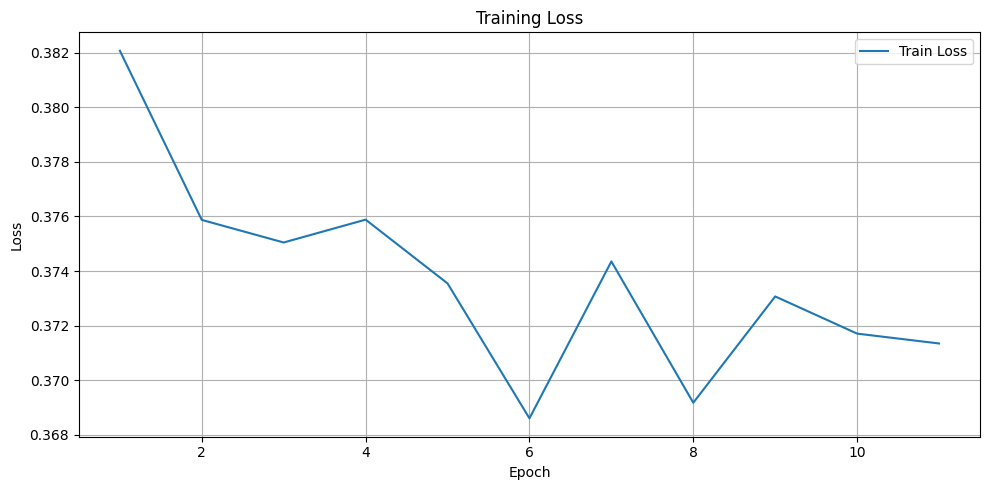

Train loss curve saved to train_loss_curve.png


In [12]:
import os
import numpy as np
from copy import deepcopy
from tqdm import tqdm

import torch
from torch.cuda.amp import autocast, GradScaler
from torch.utils.data import DataLoader
from torch.utils.tensorboard import SummaryWriter
import matplotlib.pyplot as plt

from pcdet.datasets import build_dataloader
from pcdet.models import build_network
from pcdet.utils import common_utils

logger = common_utils.create_logger()

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
scaler = GradScaler()

# -------------------------------------------------
# Helper: move batch to GPU
# -------------------------------------------------
def move_batch_to_gpu(batch_dict, device):
    for key, val in batch_dict.items():
        if isinstance(val, np.ndarray) and np.issubdtype(val.dtype, np.number):
            batch_dict[key] = torch.from_numpy(val).to(device)
        elif isinstance(val, torch.Tensor):
            batch_dict[key] = val.to(device)
        else:
            batch_dict[key] = val
    return batch_dict


# ========================================================
# 1) BUILD DATASETS & DATALOADERS
# ========================================================

# ---------- TRAIN ----------
train_set, _, train_sampler = build_dataloader(
    dataset_cfg=cfg.DATA_CONFIG,
    class_names=cfg.CLASS_NAMES,
    batch_size=4,
    dist=False,
    workers=0,   # dataset workers (we'll use manual DataLoader below)
    logger=logger,
    training=True,
    merge_all_iters_to_one_epoch=False,
    total_epochs=80,
    seed=666
)

train_loader = DataLoader(
    train_set,
    batch_size=4,
    shuffle=(train_sampler is None),
    num_workers=14,
    pin_memory=True,
    persistent_workers=True,
    drop_last=True,
    collate_fn=train_set.collate_batch
)

# ---------- VALIDATION ----------
val_cfg = deepcopy(cfg.DATA_CONFIG)
val_cfg.DATA_SPLIT.train = 'val'
val_cfg.INFO_PATH.train = ['kitti_infos_val.pkl']

# IMPORTANT: training=False for validation -> inference mode
val_set, val_loader, val_sampler = build_dataloader(
    dataset_cfg=val_cfg,
    class_names=cfg.CLASS_NAMES,
    batch_size=1,
    dist=False,
    workers=4,
    logger=logger,
    training=False
)

logger.info(f"Train samples: {len(train_set)}, Val samples: {len(val_set)}")


# ========================================================
# 2) BUILD MODEL
# ========================================================
model = build_network(
    model_cfg=cfg.MODEL,
    num_class=len(cfg.CLASS_NAMES),
    dataset=train_set
)

model = model.to(device)
model.train()
logger.info("Model built and moved to GPU.")


# ========================================================
# 3) LOAD PRETRAINED CHECKPOINT (TRANSFER LEARNING)
# ========================================================
pretrained_path = "/home/numpyyy/OpenPCDet/pretrained_models/kitti/pointpillar_7728.pth"

if os.path.exists(pretrained_path):
    checkpoint = torch.load(pretrained_path, map_location="cpu")
    missing, unexpected = model.load_state_dict(checkpoint["model_state"], strict=False)

    print(f"\n🎉 Loaded pretrained weights from: {pretrained_path}")
    print("Missing keys:", missing)
    print("Unexpected keys:", unexpected)
else:
    print(f"⚠️ Pretrained checkpoint not found at {pretrained_path}. Training from scratch.")


# ========================================================
# 4) FREEZE LAYERS (OPTIONAL TRANSFER-LEARNING TRICK)
# ========================================================
FREEZE_VFE = False
FREEZE_BACKBONE2D = True
FREEZE_DENSE_HEAD = False

if FREEZE_VFE and hasattr(model, "vfe"):
    print("👉 Freezing VFE")
    for p in model.vfe.parameters():
        p.requires_grad = False

if FREEZE_BACKBONE2D and hasattr(model, "backbone_2d"):
    print("👉 Freezing BEV Backbone (2D)")
    for p in model.backbone_2d.parameters():
        p.requires_grad = False

if FREEZE_DENSE_HEAD and hasattr(model, "dense_head"):
    print("👉 Freezing detection head")
    for p in model.dense_head.parameters():
        p.requires_grad = False

trainable_params = [p for p in model.parameters() if p.requires_grad]
total_params = sum(p.numel() for p in model.parameters())
print(f"Trainable params: {sum(p.numel() for p in trainable_params)} / {total_params}")


# ========================================================
# 5) OPTIMIZER & LR SCHEDULER
# ========================================================
base_lr = float(cfg.OPTIMIZATION.LR)
weight_decay = float(cfg.OPTIMIZATION.WEIGHT_DECAY)
pct_start = float(cfg.OPTIMIZATION.PCT_START)
div_factor = float(cfg.OPTIMIZATION.DIV_FACTOR)

optimizer = torch.optim.AdamW(trainable_params, lr=base_lr, weight_decay=weight_decay)

total_epochs = 80
steps_per_epoch = len(train_loader)
total_steps = total_epochs * steps_per_epoch

scheduler = torch.optim.lr_scheduler.OneCycleLR(
    optimizer,
    max_lr=base_lr,
    total_steps=total_steps,
    pct_start=pct_start,
    div_factor=div_factor,
    final_div_factor=div_factor * 10,
)


# ========================================================
# 6) VALIDATION STEP (NO LOSS – INFERENCE ONLY)
# ========================================================
@torch.no_grad()
def run_validation(model, val_loader, epoch, writer=None):
    """
    Simple validation loop in inference mode.
    This does NOT compute loss (PCDet's loss is training-only).
    You can extend this to run full AP evaluation using val_set.evaluation().
    """
    model.eval()
    num_batches = 0

    # Optionally count how many predictions we get (just as a sanity metric)
    total_detections = 0

    for batch_idx, batch_dict in enumerate(tqdm(val_loader, desc=f"[Val] Epoch {epoch+1}", ncols=100)):
        batch_dict = move_batch_to_gpu(batch_dict, device)
        pred_dicts, recall_dicts = model(batch_dict)  # PCDet returns detections in eval mode

        # pred_dicts is a list of dicts, one per sample
        for pred in pred_dicts:
            total_detections += len(pred.get("pred_boxes", []))

        num_batches += 1

    avg_dets = total_detections / max(1, num_batches)

    if writer is not None:
        writer.add_scalar("Val/avg_detections_per_batch", avg_dets, epoch)

    print(f"[Val] Epoch {epoch+1}: avg detections per batch = {avg_dets:.2f}")

    model.train()
    return avg_dets  # pseudo "metric" you can track for sanity


# ========================================================
# 7) TRAINING LOOP
# ========================================================
save_dir = "/home/numpyyy/OpenPCDet/checkpoints_custom/"
os.makedirs(save_dir, exist_ok=True)

train_loss_history = []
val_metric_history = []  # we'll store avg detections as a simple sanity metric

best_train_loss = float("inf")
patience = 5
patience_counter = 0

resume_path = ""  # set to checkpoint path if you want to resume
start_epoch = 0

tb_dir = "/home/numpyyy/OpenPCDet/output/tensorboard_custom/"
writer = SummaryWriter(log_dir=tb_dir)

# -------- RESUME (optional) --------
if resume_path and os.path.exists(resume_path):
    print(f"🔄 Resuming training from checkpoint: {resume_path}")
    ckpt = torch.load(resume_path, map_location="cuda")

    model.load_state_dict(ckpt["model_state"])
    optimizer.load_state_dict(ckpt["optimizer_state"])
    scaler.load_state_dict(ckpt["scaler_state"])

    if "scheduler_state" in ckpt:
        scheduler.load_state_dict(ckpt["scheduler_state"])
        print("➡️ Scheduler state restored.")

    start_epoch = ckpt["epoch"]
    best_train_loss = ckpt.get("best_loss", best_train_loss)

    print(f"➡️ Resumed at epoch {start_epoch}, best_train_loss={best_train_loss:.4f}")
else:
    print("🆕 No checkpoint found, training from scratch.")


# -------- MAIN LOOP --------
grad_accum = 2

for epoch in range(start_epoch, total_epochs):

    model.train()
    print(f"\n===== Epoch {epoch+1}/{total_epochs} =====")

    progress = tqdm(train_loader, total=len(train_loader), ncols=100)
    optimizer.zero_grad(set_to_none=True)
    accum_counter = 0
    running_loss = 0.0

    for batch_dict in progress:
        batch_dict = move_batch_to_gpu(batch_dict, device)

        # FORWARD
        with autocast():
            batch_out = model(batch_dict)
            loss, tb_dict, disp_dict = model.get_training_loss()
            loss = loss / grad_accum

        # BACKWARD
        scaler.scale(loss).backward()
        accum_counter += 1

        if accum_counter == grad_accum:
            scaler.step(optimizer)
            scaler.update()
            optimizer.zero_grad(set_to_none=True)
            scheduler.step()
            accum_counter = 0

        progress.set_description(f"Loss: {loss.item() * grad_accum:.4f}")
        running_loss += loss.item() * grad_accum

    # TRAIN LOSS
    epoch_loss = running_loss / len(train_loader)
    print(f"Epoch {epoch+1} completed. Final Train Loss = {epoch_loss:.4f}")

    train_loss_history.append(epoch_loss)
    writer.add_scalar("Loss/train", epoch_loss, epoch)
    writer.add_scalar("LR", optimizer.param_groups[0]["lr"], epoch)

    # VALIDATION (inference-only sanity metric)
    val_metric = run_validation(model, val_loader, epoch, writer=writer)
    val_metric_history.append(val_metric)

    # SAVE LAST CHECKPOINT
    latest_ckpt = os.path.join(save_dir, "latest.pth")
    torch.save({
        "epoch": epoch + 1,
        "model_state": model.state_dict(),
        "optimizer_state": optimizer.state_dict(),
        "scaler_state": scaler.state_dict(),
        "scheduler_state": scheduler.state_dict(),
        "best_loss": best_train_loss
    }, latest_ckpt)

    # SAVE BEST (based on TRAIN LOSS – because we don't have real val loss here)
    if epoch_loss < best_train_loss:
        best_train_loss = epoch_loss
        patience_counter = 0

        best_ckpt = os.path.join(save_dir, f"best_epoch_{epoch+1}.pth")
        torch.save({
            "epoch": epoch + 1,
            "model_state": model.state_dict(),
            "optimizer_state": optimizer.state_dict(),
            "scaler_state": scaler.state_dict(),
            "best_loss": best_train_loss
        }, best_ckpt)

        print(f"🌟 New BEST model saved to {best_ckpt} (train_loss={best_train_loss:.4f})")
    else:
        patience_counter += 1
        print(f"⚠️ No improvement. Patience {patience_counter}/{patience}")

    # EARLY STOP (based on train loss plateau)
    if patience_counter >= patience:
        print("\n⛔ Early stopping triggered (train loss stalled)!")
        break


# ========================================================
# 8) SAVE LOSS ARRAYS + PLOT GRAPH
# ========================================================
np.save("train_loss.npy", np.array(train_loss_history))
np.save("val_metric.npy", np.array(val_metric_history))

epochs = np.arange(1, len(train_loss_history) + 1)

plt.figure(figsize=(10, 5))
plt.plot(epochs, train_loss_history, label="Train Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training Loss")
plt.grid()
plt.legend()
plt.tight_layout()
plt.savefig("train_loss_curve.png")
plt.show()

print("Train loss curve saved to train_loss_curve.png")


In [13]:
from pathlib import Path
from pcdet.datasets import build_dataloader
from tools.eval_utils import eval_utils
import torch, os

# ----------------------------
# Build test / validation set
# ----------------------------
test_set, test_loader, _ = build_dataloader(
    dataset_cfg=cfg.DATA_CONFIG,
    class_names=cfg.CLASS_NAMES,
    batch_size=4,
    dist=False,
    workers=4,
    logger=logger,
    training=False
)

# ----------------------------
# Load checkpoint
# ----------------------------
ckpt_path = '/home/numpyyy/OpenPCDet/checkpoints_custom/best_epoch_7.pth'
checkpoint = torch.load(ckpt_path)

model.load_state_dict(checkpoint['model_state'])
model.cuda()
model.eval()

# ----------------------------
# Minimal args object for eval
# ----------------------------
class EvalArgs:
    def __init__(self):
        self.save_to_file = True
        self.predicted_boxes_suffix = "eval"

args = EvalArgs()

# ----------------------------
# result_dir must be a Path
# ----------------------------
eval_output_dir = Path('output/eval_results_new')

# ----------------------------
# RUN EVAL (match function signature)
# tools/eval_utils/eval_utils.py:
# def eval_one_epoch(cfg, args, model, dataloader, epoch_id, logger, dist_test=False, result_dir=None):
# ----------------------------
ret_dict = eval_utils.eval_one_epoch(
    cfg=cfg,
    args=args,
    model=model,
    dataloader=test_loader,
    epoch_id=checkpoint.get("epoch", 0),
    logger=logger,
    dist_test=False,
    result_dir=eval_output_dir,
)

print("\n===== EVALUATION DONE =====")
print(ret_dict)


2025-12-14 13:34:37,019   INFO  Loading KITTI dataset
2025-12-14 13:34:37,019   INFO  Loading KITTI dataset
2025-12-14 13:34:37,019   INFO  Loading KITTI dataset
2025-12-14 13:34:37,134   INFO  Total samples for KITTI dataset: 3769
2025-12-14 13:34:37,134   INFO  Total samples for KITTI dataset: 3769
2025-12-14 13:34:37,134   INFO  Total samples for KITTI dataset: 3769
2025-12-14 13:34:37,182   INFO  *************** EPOCH 7 EVALUATION *****************
2025-12-14 13:34:37,182   INFO  *************** EPOCH 7 EVALUATION *****************
2025-12-14 13:34:37,182   INFO  *************** EPOCH 7 EVALUATION *****************
eval: 100%|████| 943/943 [04:48<00:00,  3.27it/s, recall_0.3=(0, 16483) / 17558]
2025-12-14 13:39:25,898   INFO  *************** Performance of EPOCH 7 *****************
2025-12-14 13:39:25,898   INFO  *************** Performance of EPOCH 7 *****************
2025-12-14 13:39:25,898   INFO  *************** Performance of EPOCH 7 *****************
2025-12-14 13:39:25,899  


===== EVALUATION DONE =====
{'recall/roi_0.3': 0.0, 'recall/rcnn_0.3': 0.9387743478756122, 'recall/roi_0.5': 0.0, 'recall/rcnn_0.5': 0.8783460530812165, 'recall/roi_0.7': 0.0, 'recall/rcnn_0.7': 0.6144777309488553, 'Car_aos/easy_R40': 95.25523530729, 'Car_aos/moderate_R40': 91.15060082740717, 'Car_aos/hard_R40': 89.74189288389935, 'Car_3d/easy_R40': 0.0, 'Car_3d/moderate_R40': 0.0, 'Car_3d/hard_R40': 0.0, 'Car_bev/easy_R40': 91.44308830875778, 'Car_bev/moderate_R40': 85.22799496949409, 'Car_bev/hard_R40': 84.14709149167875, 'Car_image/easy_R40': 95.28450092627043, 'Car_image/moderate_R40': 91.37832421905794, 'Car_image/hard_R40': 90.14512087704018, 'Pedestrian_aos/easy_R40': 47.10182718154193, 'Pedestrian_aos/moderate_R40': 43.754669479687, 'Pedestrian_aos/hard_R40': 40.827403475749335, 'Pedestrian_3d/easy_R40': 70.67736686638115, 'Pedestrian_3d/moderate_R40': 67.05622367942094, 'Pedestrian_3d/hard_R40': 62.898502503208874, 'Pedestrian_bev/easy_R40': 61.486723911777965, 'Pedestrian_be

In [14]:
import glob

ckpts = glob.glob("output/**/**/*.pth", recursive=True)
print("Found checkpoints:")
for c in ckpts:
    print(c)


Found checkpoints:
output/cfgs/kitti_models/pointpillar/default/ckpt/checkpoint_epoch_9.pth
output/cfgs/kitti_models/pointpillar/default/ckpt/checkpoint_epoch_1.pth
output/cfgs/kitti_models/pointpillar/default/ckpt/checkpoint_epoch_3.pth
output/cfgs/kitti_models/pointpillar/default/ckpt/checkpoint_epoch_8.pth
output/cfgs/kitti_models/pointpillar/default/ckpt/checkpoint_epoch_10.pth
output/cfgs/kitti_models/pointpillar/default/ckpt/checkpoint_epoch_2.pth
output/cfgs/kitti_models/pointpillar/default/ckpt/checkpoint_epoch_7.pth
output/cfgs/kitti_models/pointpillar/default/ckpt/checkpoint_epoch_6.pth
output/cfgs/kitti_models/pointpillar/default/ckpt/checkpoint_epoch_4.pth
output/cfgs/kitti_models/pointpillar/default/ckpt/checkpoint_epoch_5.pth
output/cfgs/kitti_models/pointpillar/default/ckpt/latest_model.pth
output/cfgs/kitti_models/pointpillar/default/ckpt/checkpoint_epoch_9.pth
output/cfgs/kitti_models/pointpillar/default/ckpt/checkpoint_epoch_1.pth
output/cfgs/kitti_models/pointpillar/

In [14]:
ckpt_path = "/home/numpyyy/OpenPCDet/checkpoints_custom/best_epoch_6.pth"


In [15]:
from pcdet.models import build_network
from pcdet.utils import common_utils

model = build_network(
    model_cfg=cfg.MODEL,
    num_class=len(cfg.CLASS_NAMES),
    dataset=train_set
)

model.load_params_from_file(ckpt_path, logger=logger)
model.cuda()
model.eval()


2025-12-14 14:10:24,968   INFO  ==> Loading parameters from checkpoint /home/numpyyy/OpenPCDet/checkpoints_custom/best_epoch_6.pth to GPU
2025-12-14 14:10:24,968   INFO  ==> Loading parameters from checkpoint /home/numpyyy/OpenPCDet/checkpoints_custom/best_epoch_6.pth to GPU
2025-12-14 14:10:24,968   INFO  ==> Loading parameters from checkpoint /home/numpyyy/OpenPCDet/checkpoints_custom/best_epoch_6.pth to GPU
2025-12-14 14:10:25,001   INFO  ==> Done (loaded 127/127)
2025-12-14 14:10:25,001   INFO  ==> Done (loaded 127/127)
2025-12-14 14:10:25,001   INFO  ==> Done (loaded 127/127)


PointPillar(
  (vfe): PillarVFE(
    (pfn_layers): ModuleList(
      (0): PFNLayer(
        (linear): Linear(in_features=10, out_features=64, bias=False)
        (norm): BatchNorm1d(64, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
      )
    )
  )
  (backbone_3d): None
  (map_to_bev_module): PointPillarScatter()
  (pfe): None
  (backbone_2d): BaseBEVBackbone(
    (blocks): ModuleList(
      (0): Sequential(
        (0): ZeroPad2d((1, 1, 1, 1))
        (1): Conv2d(64, 64, kernel_size=(3, 3), stride=(2, 2), bias=False)
        (2): BatchNorm2d(64, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
        (3): ReLU()
        (4): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (5): BatchNorm2d(64, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
        (6): ReLU()
        (7): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (8): BatchNorm2d(64, eps=0.001, moment

In [16]:
sample_idx = 1

# sample already voxelized
data_raw = train_set[sample_idx]

# collate into a batch (needed)
batch_dict = train_set.collate_batch([data_raw])

# move numeric arrays to GPU
batch_dict = move_batch_to_gpu(batch_dict, device)

# inference
model.eval()
with torch.no_grad():
    pred_dicts, recall_dicts = model(batch_dict)

pred = pred_dicts[0]
print("Pred keys:", pred.keys())


Pred keys: dict_keys(['pred_boxes', 'pred_scores', 'pred_labels'])


In [17]:
import numpy as np
import cv2
import torch
import matplotlib.pyplot as plt
from pcdet.utils.box_utils import boxes_to_corners_3d


def visualize_kitti_prediction(model, dataset, index=0, score_thresh=0.1, figsize=(15,5)):
    data_raw = dataset[index]
    frame_id = data_raw["frame_id"]
    calib = data_raw["calib"]

    # Determine split
    split = "training" if (dataset.root_path / "training").exists() else "testing"

    img_path = dataset.root_path / split / "image_2" / f"{frame_id}.png"
    img = cv2.imread(str(img_path))
    if img is None:
        raise FileNotFoundError(f"Image not found at {img_path}")
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    # Build minimal batch
    batch = {
        "points": torch.from_numpy(data_raw["points"]).float().cuda(),
        "frame_id": [frame_id],
        "batch_size": 1,
    }

    if "voxels" in data_raw:
        batch["voxels"] = torch.from_numpy(data_raw["voxels"]).cuda()
    if "voxel_coords" in data_raw:
        coords = data_raw["voxel_coords"]
        # pad coord to [batch_idx, z, y, x]
        if coords.shape[1] == 3:
            coords = np.pad(coords, ((0,0),(1,0)), constant_values=0)
        batch["voxel_coords"] = torch.from_numpy(coords).cuda()
    if "voxel_num_points" in data_raw:
        batch["voxel_num_points"] = torch.from_numpy(data_raw["voxel_num_points"]).cuda()

    # Run inference
    model.eval()
    with torch.no_grad():
        pred_dicts, _ = model(batch)

    pred = pred_dicts[0]
    boxes = pred["pred_boxes"].cpu().numpy()
    scores = pred["pred_scores"].cpu().numpy()

    # Filter
    keep = scores >= score_thresh
    boxes = boxes[keep]

    if len(boxes) == 0:
        print("No detections >= threshold")
        plt.imshow(img); plt.axis("off"); plt.show()
        return

    # -----------------------------
    # CORNERS IN LIDAR FRAME
    # -----------------------------
    corners_lidar = boxes_to_corners_3d(boxes)    # (N, 8, 3)
    corners_flat = corners_lidar.reshape(-1, 3)   # (N*8, 3)

    # -----------------------------
    # PROJECT USING KITTI LIDAR→IMG
    # -----------------------------
    uv, depth = calib.lidar_to_img(corners_flat)        # (N*8, 2)
    uv = uv.reshape(-1, 8, 2)                     # (N, 8, 2)

    # -----------------------------
    # Draw 3D boxes
    # -----------------------------
    def draw_box(img, pts, color=(0,255,0)):
        pts = pts.astype(int)
        edges = [
            (0,1),(1,2),(2,3),(3,0),
            (4,5),(5,6),(6,7),(7,4),
            (0,4),(1,5),(2,6),(3,7)
        ]
        for i,j in edges:
            x1, y1 = pts[i]
            x2, y2 = pts[j]
            # Only draw inside image bounds
            if (0 <= x1 < img.shape[1] and 0 <= y1 < img.shape[0] and
                0 <= x2 < img.shape[1] and 0 <= y2 < img.shape[0]):
                cv2.line(img, (x1, y1), (x2, y2), color, 2)

    img_draw = img.copy()
    for pts in uv:
        draw_box(img_draw, pts)

    plt.figure(figsize=figsize)
    plt.imshow(img_draw)
    plt.axis("off")
    plt.show()

    return img_draw


In [18]:
from pcdet.datasets import build_dataloader

# Build a test/inference loader (single-GPU, no GT expected)
test_set, test_loader, _ = build_dataloader(
    dataset_cfg=cfg.DATA_CONFIG,
    class_names=cfg.CLASS_NAMES,
    batch_size=1,
    dist=False,
    workers=4,
    logger=None,
    training=False   # IMPORTANT
)



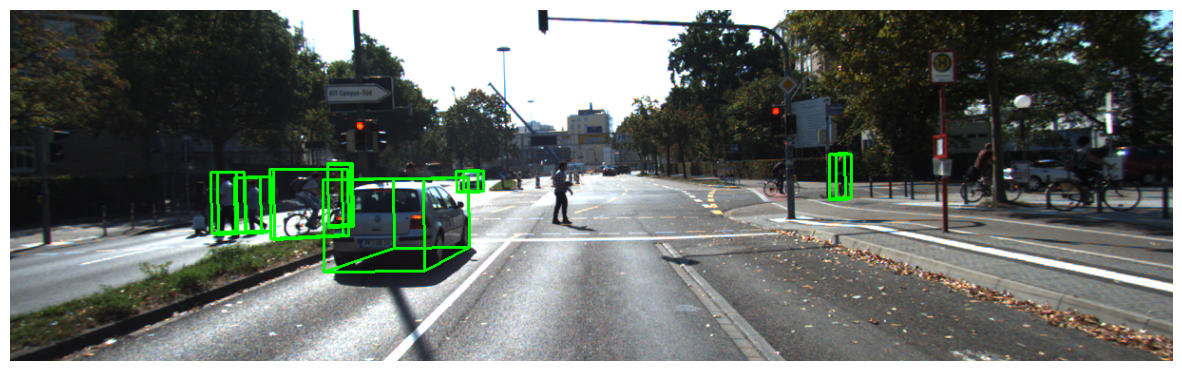

array([[[ 44,  46,  30],
        [ 44,  39,  30],
        [ 41,  34,  29],
        ...,
        [151, 210, 255],
        [133, 193, 248],
        [127, 190, 201]],

       [[ 47,  49,  28],
        [ 46,  43,  31],
        [ 45,  37,  32],
        ...,
        [118, 165, 255],
        [ 85, 177, 247],
        [ 93, 199, 236]],

       [[ 35,  36,  28],
        [ 36,  38,  31],
        [ 36,  38,  34],
        ...,
        [139, 197, 252],
        [135, 208, 255],
        [146, 217, 255]],

       ...,

       [[ 59,  59,  57],
        [ 56,  55,  46],
        [ 49,  49,  49],
        ...,
        [139, 104,  52],
        [141, 106,  54],
        [148,  98,  55]],

       [[ 37,  45,  51],
        [ 33,  36,  39],
        [ 18,  32,  36],
        ...,
        [172,  72,  54],
        [104,  77,  53],
        [ 83,  75,  55]],

       [[ 34,  24,  19],
        [ 28,  20,  16],
        [ 20,  20,  17],
        ...,
        [165,  75,  63],
        [114,  72,  62],
        [ 78,  71,  62]]

In [28]:
visualize_kitti_prediction(model, test_set, index=56, score_thresh=0.5)


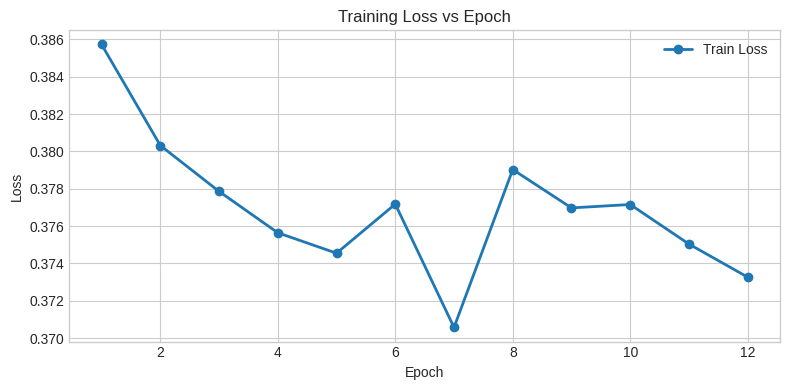

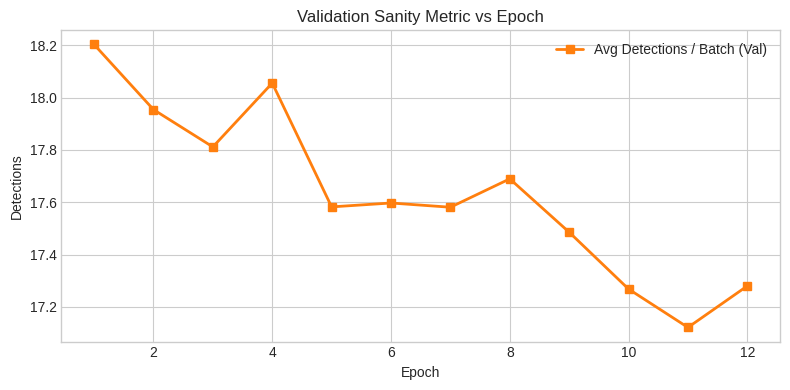

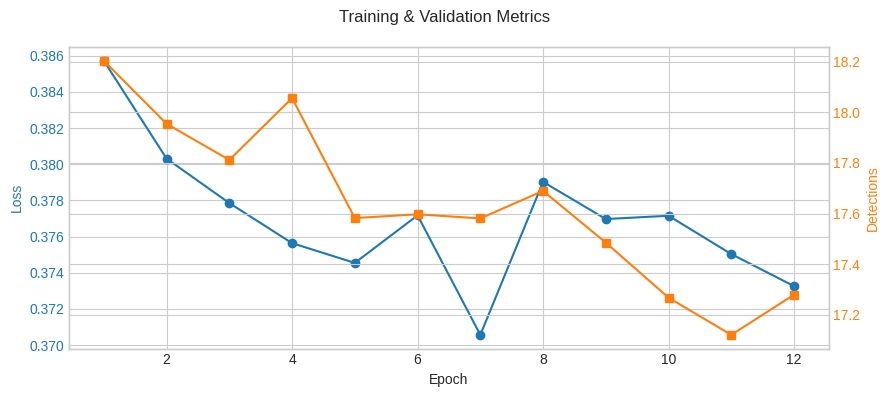

In [24]:
import numpy as np
import matplotlib.pyplot as plt

# ----------------------------
# LOAD METRICS
# ----------------------------
train_loss = np.load("train_loss.npy")
val_metric = np.load("val_metric.npy")

epochs = np.arange(1, len(train_loss) + 1)

# ----------------------------
# STYLE (clean, paper-like)
# ----------------------------
plt.style.use("seaborn-v0_8-whitegrid")

# ----------------------------
# FIGURE 1 — TRAIN LOSS
# ----------------------------
plt.figure(figsize=(8, 4))
plt.plot(epochs, train_loss, marker="o", linewidth=2, label="Train Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training Loss vs Epoch")
plt.legend()
plt.tight_layout()
plt.show()

# ----------------------------
# FIGURE 2 — VALIDATION METRIC
# ----------------------------
plt.figure(figsize=(8, 4))
plt.plot(
    epochs,
    val_metric,
    marker="s",
    linewidth=2,
    color="tab:orange",
    label="Avg Detections / Batch (Val)"
)
plt.xlabel("Epoch")
plt.ylabel("Detections")
plt.title("Validation Sanity Metric vs Epoch")
plt.legend()
plt.tight_layout()
plt.show()

# ----------------------------
# FIGURE 3 — COMBINED VIEW
# ----------------------------
fig, ax1 = plt.subplots(figsize=(9, 4))

ax1.plot(epochs, train_loss, marker="o", label="Train Loss", color="tab:blue")
ax1.set_xlabel("Epoch")
ax1.set_ylabel("Loss", color="tab:blue")
ax1.tick_params(axis="y", labelcolor="tab:blue")

ax2 = ax1.twinx()
ax2.plot(
    epochs,
    val_metric,
    marker="s",
    label="Val Detections",
    color="tab:orange"
)
ax2.set_ylabel("Detections", color="tab:orange")
ax2.tick_params(axis="y", labelcolor="tab:orange")

fig.suptitle("Training & Validation Metrics")
fig.tight_layout()
plt.show()


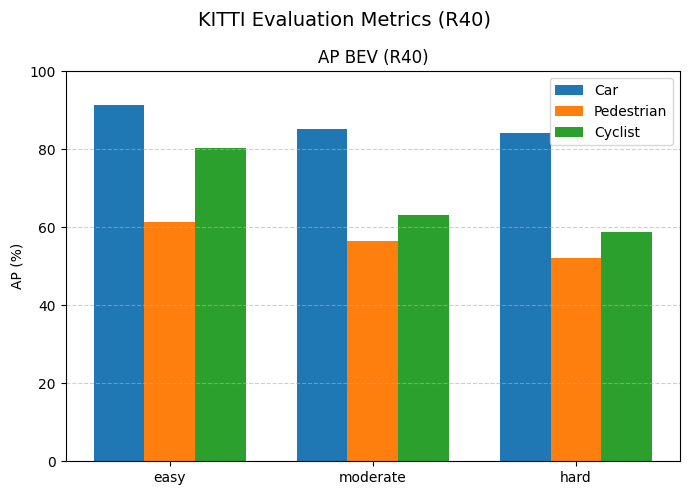

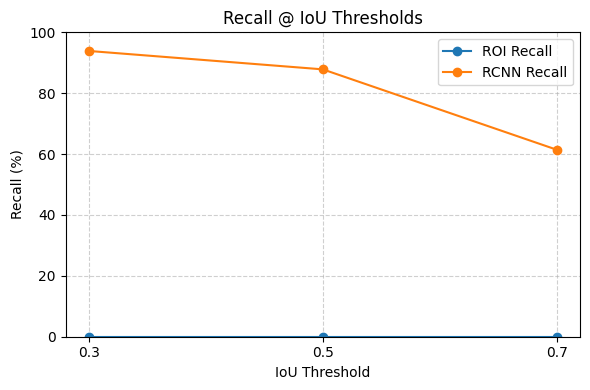

In [43]:
import matplotlib.pyplot as plt
import numpy as np

# ---------------------------------
# CONFIG
# ---------------------------------
CLASSES = ["Car", "Pedestrian", "Cyclist"]
DIFFICULTIES = ["easy", "moderate", "hard"]
METRICS = {
    "bev": "AP BEV (R40)"
}

# ---------------------------------
# Helper to fetch metric safely
# ---------------------------------
def get_metric(d, cls, metric, diff):
    key = f"{cls}_{metric}/{diff}_R40"
    return d.get(key, np.nan)

# ---------------------------------
# AP BEV BAR PLOT ONLY
# ---------------------------------
fig, ax = plt.subplots(1, 1, figsize=(7, 5))

metric_key, title = list(METRICS.items())[0]

values = []
for cls in CLASSES:
    cls_vals = [get_metric(ret_dict, cls, metric_key, d) for d in DIFFICULTIES]
    values.append(cls_vals)

x = np.arange(len(DIFFICULTIES))
width = 0.25

for i, cls in enumerate(CLASSES):
    ax.bar(
        x + i * width,
        values[i],
        width,
        label=cls
    )

ax.set_xticks(x + width)
ax.set_xticklabels(DIFFICULTIES)
ax.set_ylim(0, 100)
ax.set_title(title)
ax.set_ylabel("AP (%)")
ax.grid(axis="y", linestyle="--", alpha=0.6)
ax.legend()
plt.suptitle("KITTI Evaluation Metrics (R40)", fontsize=14)
plt.tight_layout()
plt.show()

# ---------------------------------
# 2) RECALL CURVES (ROI vs RCNN)
# ---------------------------------
recall_thresholds = ["0.3", "0.5", "0.7"]

roi_recall = [ret_dict.get(f"recall/roi_{t}", 0) * 100 for t in recall_thresholds]
rcnn_recall = [ret_dict.get(f"recall/rcnn_{t}", 0) * 100 for t in recall_thresholds]

plt.figure(figsize=(6, 4))
plt.plot(recall_thresholds, roi_recall, marker="o", label="ROI Recall")
plt.plot(recall_thresholds, rcnn_recall, marker="o", label="RCNN Recall")

plt.title("Recall @ IoU Thresholds")
plt.xlabel("IoU Threshold")
plt.ylabel("Recall (%)")
plt.ylim(0, 100)
plt.grid(True, linestyle="--", alpha=0.6)
plt.legend()
plt.tight_layout()
plt.show()


In [31]:
ret_dict

{'recall/roi_0.3': 0.0,
 'recall/rcnn_0.3': 0.9387743478756122,
 'recall/roi_0.5': 0.0,
 'recall/rcnn_0.5': 0.8783460530812165,
 'recall/roi_0.7': 0.0,
 'recall/rcnn_0.7': 0.6144777309488553,
 'Car_aos/easy_R40': 95.25523530729,
 'Car_aos/moderate_R40': 91.15060082740717,
 'Car_aos/hard_R40': 89.74189288389935,
 'Car_3d/easy_R40': 0.0,
 'Car_3d/moderate_R40': 0.0,
 'Car_3d/hard_R40': 0.0,
 'Car_bev/easy_R40': 91.44308830875778,
 'Car_bev/moderate_R40': 85.22799496949409,
 'Car_bev/hard_R40': 84.14709149167875,
 'Car_image/easy_R40': 95.28450092627043,
 'Car_image/moderate_R40': 91.37832421905794,
 'Car_image/hard_R40': 90.14512087704018,
 'Pedestrian_aos/easy_R40': 47.10182718154193,
 'Pedestrian_aos/moderate_R40': 43.754669479687,
 'Pedestrian_aos/hard_R40': 40.827403475749335,
 'Pedestrian_3d/easy_R40': 70.67736686638115,
 'Pedestrian_3d/moderate_R40': 67.05622367942094,
 'Pedestrian_3d/hard_R40': 62.898502503208874,
 'Pedestrian_bev/easy_R40': 61.486723911777965,
 'Pedestrian_bev/mo

In [32]:
sample = val_set[0]
gt = sample["gt_boxes"]  # (N,7) [x,y,z,dx,dy,dz,yaw] in lidar convention used by dataset
print(gt.shape, gt[:3])

# show car-only stats if gt_names exists
if "gt_names" in sample:
    car_mask = (sample["gt_names"] == "Car")
    print("Car GT count:", car_mask.sum())
    print("Car z mean/min/max:", gt[car_mask,2].mean(), gt[car_mask,2].min(), gt[car_mask,2].max())
    print("Car dz mean/min/max:", gt[car_mask,5].mean(), gt[car_mask,5].min(), gt[car_mask,5].max())


(2, 8) [[ 5.8780804e+01  1.6559635e+01 -8.4111089e-01  3.6900001e+00
   1.8700000e+00  1.6700000e+00 -3.1407964e+00  1.0000000e+00]
 [ 4.6125271e+01 -4.5720663e+00 -3.1538665e-02  2.0200000e+00
   6.0000002e-01  1.8600000e+00 -2.0796418e-02  3.0000000e+00]]
